In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification, BertModel, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import random
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import random
from timeit import default_timer
import torch.nn.functional as F

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 19.0MB/s 
     |████████████████████████████████| 901kB 43.2MB/s 
     |████████████████████████████████| 3.3MB 52.9MB/s 


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


In [3]:
#clear memory
torch.cuda.empty_cache() 

In [4]:
#hyperparameters
batch_size = 14
epochs = 10
learning_rate = 2e-5
eps = 1e-8
bertinputmodel = 'bert-base-uncased'
bestmodelpath = "bertmodel10k.model"

#seed for model
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#load data, drop na, remove unknowns
df = pd.read_csv("/content/drive/MyDrive/Team 9: RelAIability/FNC - Dataset/news1m.csv", nrows = 10000)
df = df.loc[:,["type","content"]].dropna()
df= df[df["type"] != "unknown"]

#map to num
list_of_tags = df.type.unique()
df['type_num'] = ""
label_dict = {}
for i, tag in enumerate(list_of_tags):
        df.loc[df.type == tag, 'type_num']= i
        label_dict[tag] = i

In [7]:
list_of_tags = df.type.unique()
print(list_of_tags)

['rumor' 'hate' 'unreliable' 'conspiracy' 'clickbait' 'satire' 'fake'
 'reliable' 'bias' 'political' 'junksci']


In [8]:
#tokenize the testing and training data
train_data, validate_data, test_data = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
train_data = train_data.reset_index(drop=True)
validate_data = validate_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [9]:
np.unique(train_data.type_num)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object)

In [10]:
#weights for all classes
newsweights = compute_class_weight("balanced", np.unique(train_data.type_num), train_data.type_num)

In [11]:
newsweights

array([14.19617225,  3.43601621,  1.86018809,  0.28956229,  4.90413223,
        4.35043988,  0.24147473,  4.57164869,  5.86363636,  0.94807477,
        1.59131134])

In [12]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [13]:
#PAD: pad token to make sequence lengths even, 0
#SEP: separation token, 102
#CLS: classification token for text, 101
#UNK: unknown token aka no token ID, 100
#encode the text data
#input ids for encoding, attention masks to identify which encodings contain information,
#token type IDs for segment IDS (though it's not relevant here)
def text_to_enc(tokenizer, content_data, max_len, sptokens = True, mask = True, segIDs = False, tensor = 'pt'):
    encoding =  tokenizer.batch_encode_plus(
                    content_data, #input
                    max_length = max_len,#fixed length of sequence
                    add_special_tokens = sptokens, #add special tokens
                    padding = True, #make all sequences same length
                    return_attention_mask = mask, 
                    return_token_type_ids = segIDs,
                    truncation = True, #cutoff
                    return_tensors = tensor)
    return encoding

#encoding ID dictionaries
encoded_data_train = text_to_enc(bert_tokenizer, train_data.content.values, 512)
encoded_data_val = text_to_enc(bert_tokenizer, validate_data.content.values, 512)
encoded_data_test = text_to_enc(bert_tokenizer, test_data.content.values, 512)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data.type_num)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(validate_data.type_num)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_data.type_num)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [14]:
#inputs into network
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)


In [15]:
#bertmodel
class NewsCLF(nn.Module):
        ## constructor
        """Bert Model for Classification"""
        def __init__(self, bert):
            super(NewsCLF, self).__init__()

            #create architecture
            self.bert = bert #input bert model as first layer
            
            self.dropout1 = nn.Dropout(0.2) #drop 20% of data set
            
            #add one hidden layer and classification layer
            self.clf = nn.Sequential(nn.Linear(768, 50), #50 or 150 neurons
                                  nn.ReLU(), #activation function
                                  nn.Dropout(0.2),  
                                  nn.Linear(50, len(label_dict)))
            
            
        def forward(self, sent_id, mask):
            """inputs into bert and return last layter outputs"""
            #extract last output layer 
            bert_outputs = self.bert(input_ids = sent_id, attention_mask = mask)
            
            #get pooled outputs
            pooled_outputs = bert_outputs[0][:,0,:] #last hidden state, (bs, seq_len, dim)
            
            #feed into model
            pooled_outputs = self.dropout1(pooled_outputs)
            
            #hidden layer to classification/output layer, logits
            clf = self.clf(pooled_outputs)
            
            return clf

In [16]:
config = BertConfig(dropout= 0.1, 
                          attention_dropout= 0.1)


bertsequence = BertModel.from_pretrained(bertinputmodel, config = config)
#load model
model = NewsCLF(bertsequence)

#turn newsweights into a tensor and pass to gpu
model.to(device)

#loss function
newsweightstensor = torch.tensor(newsweights, dtype = torch.float)
newsweightstensor.to(device) #push to gpu
cross_entropy = nn.CrossEntropyLoss(weight = newsweightstensor)
cross_entropy.to(device)

CrossEntropyLoss()

In [17]:
optimizer = AdamW(model.parameters(),
                  lr=learning_rate, 
                  eps=eps)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = len(dataloader_train) * epochs)

In [18]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [19]:
def train(dataloader_train):
    model.train()
    
    loss_train_total = 0
    # empty list to for model predictions and real values
    predictions, true_train = [], []
  
    # iterate over batches
    for step,batch in enumerate(dataloader_train):
        
        # clear previously calculated gradients 
        model.zero_grad()  
        
        # update every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader_train)))
            
        # load batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # forward pass for logits
        preds = model(sent_id, mask)

        # compute loss between true and predicted values
        loss = cross_entropy(preds, labels)
        loss_train_total += loss.item() #add to total loss

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0, prevent the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()
        scheduler.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        labels = labels.cpu().numpy()

        # append the model predictions
        predictions.append(preds)
        true_train.append(labels)

    # compute the training loss of the epoch
    loss_train_avg = loss_train_total / len(dataloader_train)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    predictions  = np.concatenate(predictions, axis=0)
    true_train = np.concatenate(true_train, axis=0)
    
    return loss_train_avg, predictions, true_train

In [20]:
def evaluate(dataloader_val, test = False):
    print("\nEvaluating...")
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    #iterate over batches
    for step,batch in enumerate(dataloader_val):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader_val)))
        
        batch = [b.to(device) for b in batch]
        
        sent_id, mask, labels = batch

        with torch.no_grad():        
            preds = model(sent_id, mask)
        
        loss = cross_entropy(preds,labels)
        loss_val_total += loss.item()

        preds = preds.detach().cpu().numpy()
        labels = labels.cpu().numpy()
        predictions.append(preds)
        true_vals.append(labels)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    if test == True:
      predictions = F.softmax(torch.tensor(predictions), dim=1).cpu().numpy()
            
    return loss_val_avg, predictions, true_vals

In [21]:
#reset weights
def weight_reset(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

model.apply(weight_reset)

NewsCLF(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
#train model
best_valid_loss = float('inf')
train_loss, val_loss, trainf1, valf1, trainacc, valacc = [],[],[],[],[],[]
start_time=default_timer()
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    loss_train_avg, predictions, true_train = train(dataloader_train)

    train_loss.append(loss_train_avg)

    train_f1 = f1_score_func(predictions, true_train)
    trainf1.append(train_f1)

    trainpredvec = np.argmax(predictions, axis = 1)
    train_acc = accuracy_score(true_train,trainpredvec)
    trainacc.append(train_acc)
    print(f'Training loss: {loss_train_avg}')
    print(f'Train F1 Score (Weighted): {train_f1}')
    print(f'Train Accuracy: {train_acc}')
        
    loss_val_avg, valpredictions, true_val = evaluate(dataloader_validation)
            
        
    if loss_val_avg < best_valid_loss:
        best_valid_loss = loss_val_avg
        torch.save(model.state_dict(), bestmodelpath)
        
    val_loss.append(loss_val_avg)
    print(f'Validation loss: {loss_val_avg}')
    
    val_f1 = f1_score_func(valpredictions, true_val)
    valf1.append(val_f1)
    print(f'Val F1 Score (Weighted): {val_f1}')
    
    valpredvec = np.argmax(valpredictions, axis = 1)
    val_acc = accuracy_score(true_val, valpredvec)
    valacc.append(val_acc)
    print(f'Val Accuracy: {val_acc}')

end_time=default_timer()
print ('Elapsed training time: {0}s'.format(end_time-start_time))
    


 Epoch 1 / 10
  Batch    50  of    424.
  Batch   100  of    424.
  Batch   150  of    424.
  Batch   200  of    424.
  Batch   250  of    424.
  Batch   300  of    424.


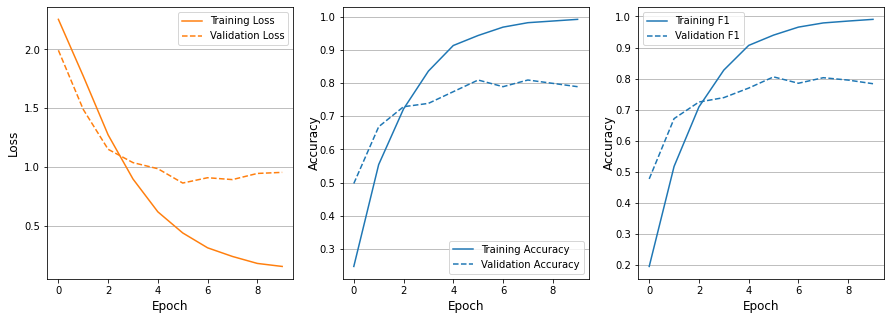

In [35]:
plt.figure(1, figsize = (15,5))
plt.subplot(1,3,1)
plt.plot(range(epochs), train_loss, color = "#ff7f0e")
plt.plot(range(epochs), val_loss,"--", color = "#ff7f0e")
plt.xlabel("Epoch", size = 12)
plt.ylabel("Loss", size = 12)
plt.grid(axis = 'y')
plt.legend(["Training Loss", "Validation Loss"])

plt.subplot(1,3,2)
plt.plot(range(epochs), trainacc, color = "#1f77b4")
plt.plot(range(epochs), valacc,"--", color = "#1f77b4")
plt.xlabel("Epoch", size = 12)
plt.ylabel("Accuracy", size = 12, labelpad= -1 )
plt.grid(axis = 'y')
plt.legend(["Training Accuracy", "Validation Accuracy"])

plt.subplot(1,3,3)
plt.plot(range(epochs), trainf1, color = "#1f77b4")
plt.plot(range(epochs), valf1,"--", color = "#1f77b4")
plt.xlabel("Epoch", size = 12)
plt.ylabel("Accuracy", size = 12, labelpad= -1 )
plt.grid(axis = 'y')
plt.legend(["Training F1", "Validation F1"])
plt.savefig("plotvalacc.png", dpi = 300)

In [36]:
testloss, testpredictions, true_test = evaluate(dataloader_test, test = True)
accuracy_per_class(testpredictions, true_test)


Evaluating...
Class: hate
Accuracy: 16/16

Class: unreliable
Accuracy: 31/42

Class: conspiracy
Accuracy: 32/39

Class: clickbait
Accuracy: 18/21

Class: satire
Accuracy: 22/27

Class: fake
Accuracy: 17/21

Class: reliable
Accuracy: 8/8

Class: bias
Accuracy: 5/8

Class: political
Accuracy: 10/11

Class: junksci
Accuracy: 0/6



In [37]:
testpredictions1 = np.argmax(testpredictions, axis = 1)
print(classification_report(true_test,testpredictions1))

              precision    recall  f1-score   support

           1       0.84      1.00      0.91        16
           2       0.74      0.74      0.74        42
           3       0.70      0.82      0.75        39
           4       0.75      0.86      0.80        21
           5       0.96      0.81      0.88        27
           6       1.00      0.81      0.89        21
           7       1.00      1.00      1.00         8
           8       0.83      0.62      0.71         8
           9       0.71      0.91      0.80        11
          10       0.00      0.00      0.00         6

    accuracy                           0.80       199
   macro avg       0.75      0.76      0.75       199
weighted avg       0.79      0.80      0.79       199



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
